In [12]:
import pandas as pd

ground_truth_df = pd.read_csv('output/ground_truth.csv', index_col=0)
ground_truth_df.columns = ['findSigExposures',	'best_columns',	'Sample Names',	'Cancer Types']
ground_truth_df.head()


,findSigExposures,best_columns,Sample Names,Cancer Types
0,0.073905,4,499,in_sample_Skin-Melanoma
1,0.700639,6,499,in_sample_Skin-Melanoma
2,0.163932,7,499,in_sample_Skin-Melanoma
3,0.026822,8,499,in_sample_Skin-Melanoma
4,0.034701,9,499,in_sample_Skin-Melanoma


In [13]:
ground_truth_df['Sample Names'] = ground_truth_df['Sample Names'].astype(str)

In [14]:
experiment_df = pd.read_csv('output/experiment.csv', index_col=0)
experiment_df.columns = ['findSigExposures',	'best_columns',	'Sample Names',	'Cancer Types']
experiment_df.head()

,findSigExposures,best_columns,Sample Names,Cancer Types
0,0.073230,4,499,Test
1,0.700800,6,499,Test
2,0.166505,7,499,Test
3,0.026334,8,499,Test
4,0.033130,9,499,Test


In [15]:
experiment_df['Sample Names'] = experiment_df['Sample Names'].astype(str)

In [16]:
experiment_sig_profiler_df = pd.read_csv('output/experiment_sig_profiles.csv', index_col=0)
experiment_sig_profiler_df.columns = ['findSigExposures',	'best_columns',	'Sample Names',	'Cancer Types']
experiment_sig_profiler_df.head()

,findSigExposures,best_columns,Sample Names,Cancer Types
0,0.00002,0,499,Head-SCC
1,0.07386,4,499,Head-SCC
2,0.70026,6,499,Head-SCC
3,0.16638,7,499,Head-SCC
4,0.02636,8,499,Head-SCC


In [17]:
experiment_signal_df = pd.read_csv('output/experiment_signal.csv', index_col=0)
experiment_signal_df.columns = ['findSigExposures',	'best_columns',	'Sample Names',	'Cancer Types']
experiment_signal_df['Sample Names'] = experiment_signal_df['Sample Names'].astype(str)
experiment_signal_df.head()

,findSigExposures,best_columns,Sample Names,Cancer Types
0,0.812113,6,499,Head-SCC
1,0.187887,7,499,Head-SCC
2,0.902839,6,498,Head-SCC
3,0.097161,7,498,Head-SCC
4,0.574088,6,497,Head-SCC


In [18]:
def calculate_metrics(predicted, actual, total_values):
    predicted_set = set(predicted)
    actual_set = set(actual)
    all_values_set = set(range(total_values))

    true_positives = len(predicted_set.intersection(actual_set))
    true_negatives = len(all_values_set.difference(actual_set).difference(predicted_set))

    false_negatives = actual_set.difference(predicted_set)
    false_positives = predicted_set.difference(actual_set)

    total_positives = len(actual_set)
    total_negatives = total_values - total_positives

    sensitivity = true_positives / total_positives if total_positives else 0
    specificity = true_negatives / total_negatives if total_negatives else 0

    return sensitivity, specificity, false_negatives, false_positives


In [19]:
import pandas as pd

results = []
total_values = 67

for patient in ground_truth_df['Sample Names'].unique():
    try:
        actualExposures = ground_truth_df.groupby('Sample Names').get_group(patient)['findSigExposures'].tolist()
        actual = ground_truth_df.groupby('Sample Names').get_group(patient)['best_columns'].tolist()
        predicted = experiment_df.groupby('Sample Names').get_group(patient)['best_columns'].tolist()
        predicted_sig_profile = experiment_sig_profiler_df.groupby('Sample Names').get_group(patient)['best_columns'].tolist()
        predicted_signal = experiment_signal_df.groupby('Sample Names').get_group(patient)['best_columns'].tolist()
    except:
        print(f'error: patient', patient)
        continue
    sensitivity, specificity, false_negatives, false_positives = calculate_metrics(predicted, actual, total_values)
    sensitivity_sig_profile, specificity_sig_profile, false_negatives_sig_profile, false_positives_sig_profile = calculate_metrics(predicted_sig_profile, actual, total_values)
    sensitivity_signal, specificity_signal, false_negatives_signal, false_positives_signal = calculate_metrics(predicted_signal, actual, total_values)

    results.append({
        'Pacjent': patient,
        'Sensitivity_our': sensitivity,
        'Specificity_our': specificity,
        'Sensitivity_sig_profile':sensitivity_sig_profile,
        'Specificity_sig_profile':specificity_sig_profile,
        'Sensitivity_signal':sensitivity_signal,
        'Specificity_signal':specificity_signal,
        'actualExposures':  actualExposures,
        'false_negatives_our':  {} if len(false_negatives) == 0 else false_negatives,
        'false_positives_our': {} if len(false_positives) == 0 else false_positives,
        'false_negatives_sig_profile':  {} if len(false_negatives_sig_profile) == 0 else false_negatives_sig_profile,
        'false_positives_sig_profile': {} if len(false_positives_sig_profile) == 0 else false_positives_sig_profile,
        'false_negatives_signal':  {} if len(false_negatives_signal) == 0 else false_negatives_signal,
        'false_positives_signal': {} if len(false_positives_signal) == 0 else false_positives_signal
    })

# Tworzenie DataFrame z wynikami
results_df = pd.DataFrame(results)


error: patient 0


In [20]:
import seaborn as sns 

res = []
for index, row in results_df.iterrows():
    for sig in row['false_negatives_our']:
        if sig == 0:
            res.append(row['actualExposures'][0])

<Axes: >

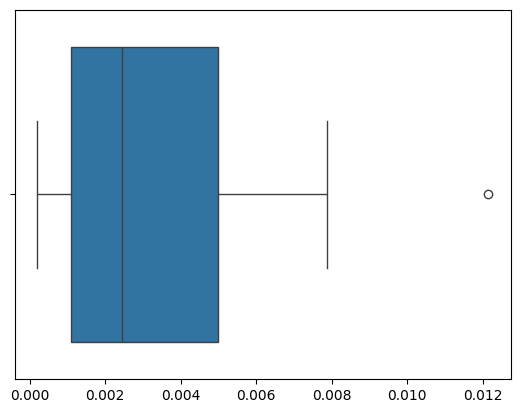

In [21]:
sns.boxplot(x=res)

In [22]:
results_df['Sensitivity_our'].mean(), results_df['Sensitivity_sig_profile'].mean(), results_df['Sensitivity_signal'].mean()

(0.9636630403664472, 0.9776529248974138, 0.7829683175875561)

In [23]:
results_df['Specificity_our'].mean(), results_df['Specificity_sig_profile'].mean(), results_df['Specificity_signal'].mean()

(0.9998351895046924, 0.9993258406213349, 1.0)

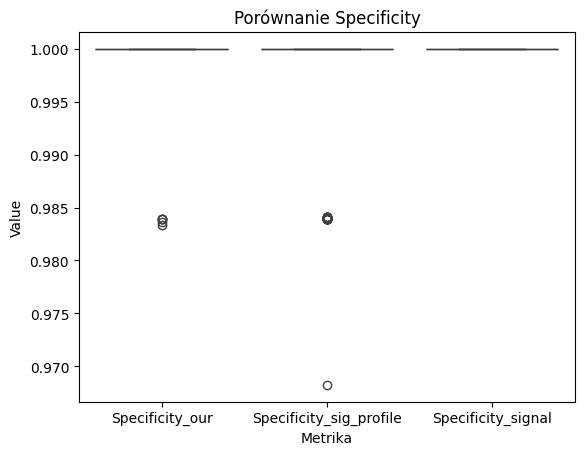

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Przekształcenie DataFrame
melted_df = results_df.melt(value_vars=['Specificity_our', 'Specificity_sig_profile', 'Specificity_signal'], var_name='Metric', value_name='Value')

# Tworzenie wykresu violin plot
sns.boxplot(x='Metric', y='Value', data=melted_df)

# Dodanie tytułu i etykiet
plt.title('Porównanie Specificity')
plt.xlabel('Metrika')
plt.ylabel('Value')

# Wyświetlenie wykresu
plt.show()

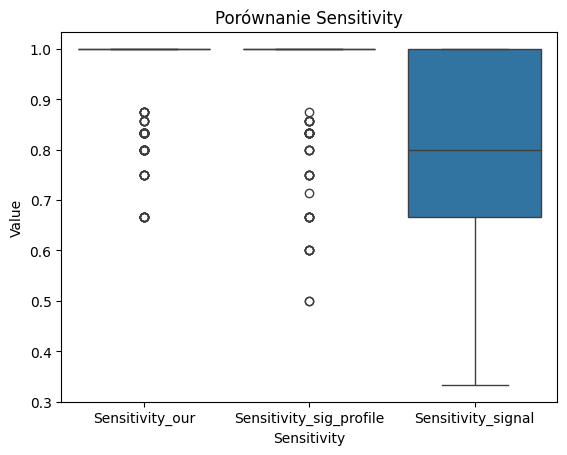

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Przekształcenie DataFrame
melted_df = results_df.melt(value_vars=['Sensitivity_our', 'Sensitivity_sig_profile', 'Sensitivity_signal'], var_name='Metric', value_name='Value')

# Tworzenie wykresu violin plot
sns.boxplot(x='Metric', y='Value', data=melted_df)

# Dodanie tytułu i etykiet
plt.title('Porównanie Sensitivity')
plt.xlabel('Sensitivity')
plt.ylabel('Value')

# Wyświetlenie wykresu
plt.show()


In [69]:
results_df

,Pacjent,Sensitivity_our,Specificity_our,Sensitivity_sig_profile,Specificity_sig_profile,Sensitivity_signal,Specificity_signal,actualExposures,false_negatives_our,false_positives_our,false_negatives_sig_profile,false_positives_sig_profile,false_negatives_signal,false_positives_signal
0,499,1.000000,1.0,1.000000,0.983871,0.400000,1.0,"[0.0739053928164786, 0.7006391677880139, 0.163...",{},{},{},{0},"{8, 9, 4}",{}
1,498,0.750000,1.0,0.500000,1.000000,0.500000,1.0,"[0.8915880394396103, 0.0845924948931173, 0.012...",{8},{},"{8, 9}",{},"{8, 9}",{}
2,497,0.857143,1.0,0.714286,1.000000,0.571429,1.0,"[0.0024488094617829, 0.0300630438180586, 0.543...",{0},{},"{9, 4}",{},"{0, 9, 4}",{}
3,496,1.000000,1.0,1.000000,1.000000,0.500000,1.0,"[0.1332697807435653, 0.0337464251668255, 0.406...",{},{},{},{},"{16, 1, 42}",{}
4,495,1.000000,1.0,1.000000,1.000000,1.000000,1.0,"[0.0862619808306709, 0.9137380191693292]",{},{},{},{},{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,5,1.000000,1.0,1.000000,1.000000,1.000000,1.0,"[0.075785896346644, 0.2533559898045879, 0.2803...",{},{},{},{},{},{}
495,4,1.000000,1.0,1.000000,1.000000,1.000000,1.0,"[0.0828963291649858, 0.0924768051633723, 0.358...",{},{},{},{},{},{}
496,3,1.000000,1.0,1.000000,1.000000,1.000000,1.0,"[0.0904325032765399, 0.2861511577107907, 0.482...",{},{},{},{},{},{}
497,2,1.000000,1.0,1.000000,1.000000,1.000000,1.0,"[0.0991573033707865, 0.273876404494382, 0.5002...",{},{},{},{},{},{}


In [70]:
import pandas as pd

signatures_false_negatives_our, signatures_false_positives_our = [], []
signatures_false_negatives_sig_profile, signatures_false_positives_sig_profile = [], []
signatures_false_negatives_signal, signatures_false_positives_signal = [], []

for idx, row in results_df.iterrows():
    for item in row['false_negatives_our']:
      signatures_false_negatives_our.append({'Count': row['Pacjent'], 'signature_false_negatives_our': item})
    for item in row['false_positives_our']:
      signatures_false_positives_our.append({'Count': row['Pacjent'], 'signature_false_positives_our': item})
    
    for item in row['false_negatives_sig_profile']:
      signatures_false_negatives_sig_profile.append({'Count': row['Pacjent'], 'signature_false_negatives_sig_profile': item})
    for item in row['false_positives_sig_profile']:
      signatures_false_positives_sig_profile.append({'Count': row['Pacjent'], 'signature_false_positives_sig_profile': item})

    for item in row['false_negatives_signal']:
      signatures_false_negatives_signal.append({'Count': row['Pacjent'], 'signature_false_negatives_signal': item})
    for item in row['false_positives_signal']:
      signatures_false_positives_signal.append({'Count': row['Pacjent'], 'signature_false_positives_signal': item})



In [96]:

# Teraz możesz wykonać grupowanie na podstawie elementów
grouped_fn_our = pd.DataFrame(signatures_false_negatives_our).groupby('signature_false_negatives_our').count().reset_index()
grouped_fp_our = pd.DataFrame(signatures_false_positives_our).groupby('signature_false_positives_our').count().reset_index()
grouped_fn_sig_profile = pd.DataFrame(signatures_false_negatives_sig_profile).groupby('signature_false_negatives_sig_profile').count().reset_index()
grouped_fp_sig_profile = pd.DataFrame(signatures_false_positives_sig_profile).groupby('signature_false_positives_sig_profile').count().reset_index()

grouped_fn_signal = pd.DataFrame(signatures_false_negatives_signal).groupby('signature_false_negatives_signal').count().reset_index()
grouped_fp_signal = 0

In [97]:
grouped_fn_our['Count'].sum(), grouped_fn_sig_profile['Count'].sum(), grouped_fn_signal['Count'].sum()
#sygnatura była istotna, a nie jest wykryta

(96, 64, 590)

In [98]:
grouped_fp_our['Count'].sum(), grouped_fp_sig_profile['Count'].sum(), grouped_fp_signal
#sygnatura nie była istotna, a jest wykryta

(6, 21, 0)

In [99]:
combined_df_fn = pd.merge(grouped_fn_our, grouped_fn_sig_profile, left_on='signature_false_negatives_our', right_on='signature_false_negatives_sig_profile', how='outer').fillna(0)
combined_df_fn = pd.merge(combined_df_fn, grouped_fn_signal, left_on='signature_false_negatives_our', right_on='signature_false_negatives_signal', how='outer').fillna(0)

In [100]:
indexes = ['SBS1', 'SBS2', 'SBS3', 'SBS4', 'SBS5', 'SBS6', 'SBS7a', 'SBS7b',
           'SBS7c', 'SBS7d', 'SBS8', 'SBS9', 'SBS10a', 'SBS10b', 'SBS11', 'SBS12',
           'SBS13', 'SBS14', 'SBS15', 'SBS16', 'SBS17a', 'SBS17b', 'SBS18',
           'SBS19', 'SBS20', 'SBS21', 'SBS22', 'SBS23', 'SBS24', 'SBS25', 'SBS26',
           'SBS27', 'SBS28', 'SBS29', 'SBS30', 'SBS31', 'SBS32', 'SBS33', 'SBS34',
           'SBS35', 'SBS36', 'SBS37', 'SBS38', 'SBS39', 'SBS40', 'SBS41', 'SBS42',
           'SBS43', 'SBS44', 'SBS45', 'SBS46', 'SBS47', 'SBS48', 'SBS49', 'SBS50',
           'SBS51', 'SBS52', 'SBS53', 'SBS54', 'SBS55', 'SBS56', 'SBS57', 'SBS58',
           'SBS59', 'SBS60', 'SBS84', 'SBS85']


mapping = {index: name for index, name in enumerate(indexes)}


In [101]:
grouped_fn_our['signatures_cat_our'] = grouped_fn_our['signature_false_negatives_our'].map(mapping)
grouped_fn_signal['signatures_cat_signal'] = grouped_fn_signal['signature_false_negatives_signal'].map(mapping)
grouped_fn_sig_profile['signatures_cat_sig_profile'] = grouped_fn_sig_profile['signature_false_negatives_sig_profile'].map(mapping)


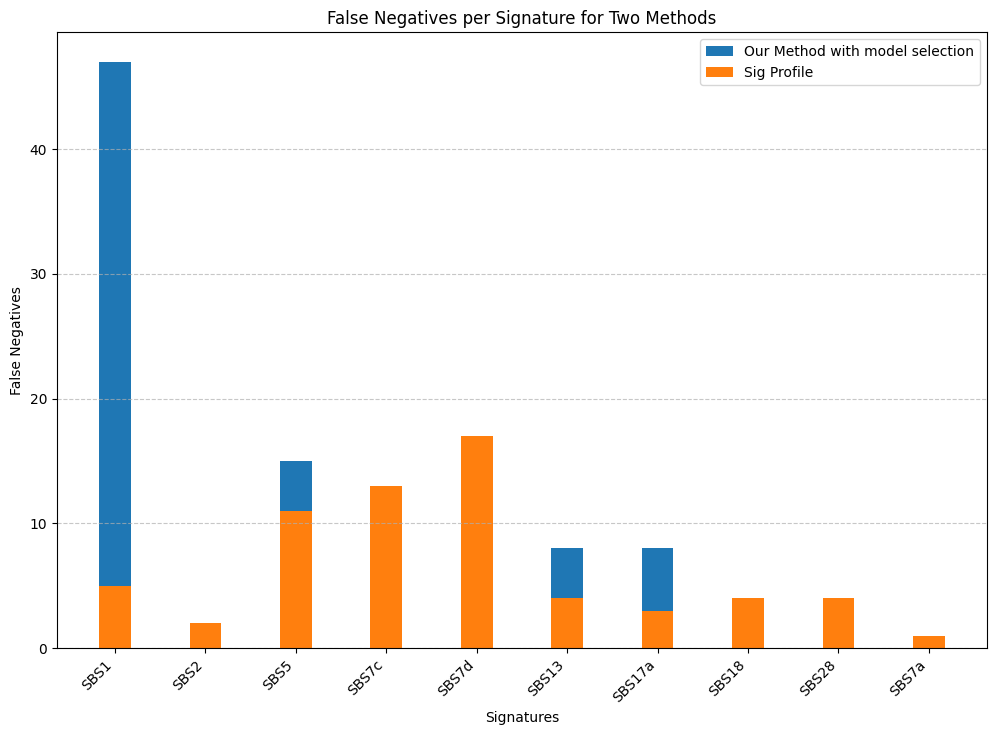

In [102]:
import matplotlib.pyplot as plt

# Twoje wcześniejsze ustawienia i dane
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35

# Rysowanie wykresów słupkowych
bar1 = ax.bar(grouped_fn_our['signatures_cat_our'], grouped_fn_our['Count'], bar_width, label='Our Method with model selection')
#bar2 = ax.bar(combined_df_fn['signature_false_negatives_sig_profile'] + bar_width/2, combined_df_fn['Count_y'], bar_width, label='Sig Profiler Assigment')
bar3 = ax.bar(grouped_fn_sig_profile['signatures_cat_sig_profile'], grouped_fn_sig_profile['Count'], bar_width, label='Sig Profile')

# Ustawienia etykiet i tytułu
ax.set_xlabel('Signatures')
ax.set_ylabel('False Negatives')
ax.set_title('False Negatives per Signature for Two Methods')
ax.legend()
plt.xticks(rotation=45, ha='right')
# Dodanie siatki i wyświetlenie wykresu
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [103]:
import pandas as pd 

df = pd.read_csv('/home/amso/Documents/mutation_signatures/output/WGS-decomposition__PCAWG_sigProfiler_SBS_signatures_in_samples.csv')

In [104]:
grouped_fp_our['signatures_cat_our'] = grouped_fp_our['signature_false_positives_our'].map(mapping)
#grouped_fp_signal['signatures_cat_signal'] = grouped_fp_signal['signature_false_positives_signal'].map(mapping)
grouped_fp_sig_profile['signatures_cat_sig_profile'] = grouped_fp_sig_profile['signature_false_positives_sig_profile'].map(mapping)


In [106]:
results_df

,Pacjent,Sensitivity_our,Specificity_our,Sensitivity_sig_profile,Specificity_sig_profile,Sensitivity_signal,Specificity_signal,actualExposures,false_negatives_our,false_positives_our,false_negatives_sig_profile,false_positives_sig_profile,false_negatives_signal,false_positives_signal
0,499,1.000000,1.0,1.000000,0.983871,0.400000,1.0,"[0.0739053928164786, 0.7006391677880139, 0.163...",{},{},{},{0},"{8, 9, 4}",{}
1,498,0.750000,1.0,0.500000,1.000000,0.500000,1.0,"[0.8915880394396103, 0.0845924948931173, 0.012...",{8},{},"{8, 9}",{},"{8, 9}",{}
2,497,0.857143,1.0,0.714286,1.000000,0.571429,1.0,"[0.0024488094617829, 0.0300630438180586, 0.543...",{0},{},"{9, 4}",{},"{0, 9, 4}",{}
3,496,1.000000,1.0,1.000000,1.000000,0.500000,1.0,"[0.1332697807435653, 0.0337464251668255, 0.406...",{},{},{},{},"{16, 1, 42}",{}
4,495,1.000000,1.0,1.000000,1.000000,1.000000,1.0,"[0.0862619808306709, 0.9137380191693292]",{},{},{},{},{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,5,1.000000,1.0,1.000000,1.000000,1.000000,1.0,"[0.075785896346644, 0.2533559898045879, 0.2803...",{},{},{},{},{},{}
495,4,1.000000,1.0,1.000000,1.000000,1.000000,1.0,"[0.0828963291649858, 0.0924768051633723, 0.358...",{},{},{},{},{},{}
496,3,1.000000,1.0,1.000000,1.000000,1.000000,1.0,"[0.0904325032765399, 0.2861511577107907, 0.482...",{},{},{},{},{},{}
497,2,1.000000,1.0,1.000000,1.000000,1.000000,1.0,"[0.0991573033707865, 0.273876404494382, 0.5002...",{},{},{},{},{},{}


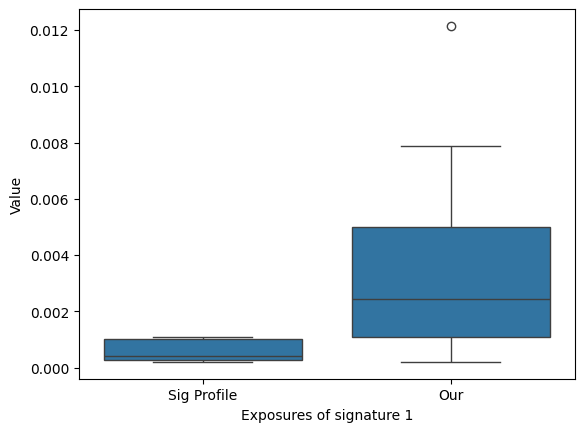

In [109]:
import seaborn as sns 
res_sig_profile = []
for index, row in results_df.iterrows():
    #sygnatura była istotna, a nie jest wykryta
    for sig in row['false_negatives_sig_profile']:
        if sig == 0:
            res_sig_profile.append(row['actualExposures'][0])

res_our = []
for index, row in results_df.iterrows():
    for sig in row['false_negatives_our']:
        if sig == 0:
            res_our.append(row['actualExposures'][0])

data = pd.DataFrame({'Value': pd.concat([pd.Series(res_sig_profile), pd.Series(res_our)], ignore_index=True),
                     'Exposures of signature 1': ['Sig Profile']*len(res_sig_profile) + ['Our']*len(res_our)})

# Rysowanie boxplotów
sns.boxplot(x='Exposures of signature 1', y='Value', data=data)

# Pokazanie wykresu
plt.show()

In [86]:
import seaborn as sns 
res_sig_profile = []
for index, row in results_df.iterrows():
    for sig in row['false_positives_sig_profile']:
        if sig ==0:
            res_sig_profile.append(row['actualExposures'][0])


#data = pd.DataFrame({'Value': pd.concat([pd.Series(res_sig_profile), pd.Series(res_our)], ignore_index=True),
#                     'Type': ['Signature Profile']*len(res_sig_profile) + ['Our Data']*len(res_our)})

# Rysowanie boxplotów

In [87]:
import numpy as np
print(np.quantile(res_sig_profile, q=[0,0.1,0.5,0.9,1]))
print(np.quantile(res_our, q=[0,0.1,0.5,0.9,1]))

[0.00765289 0.01041617 0.04147686 0.40581934 0.76568658]
[0.00020292 0.00049171 0.00244961 0.00611089 0.01214385]


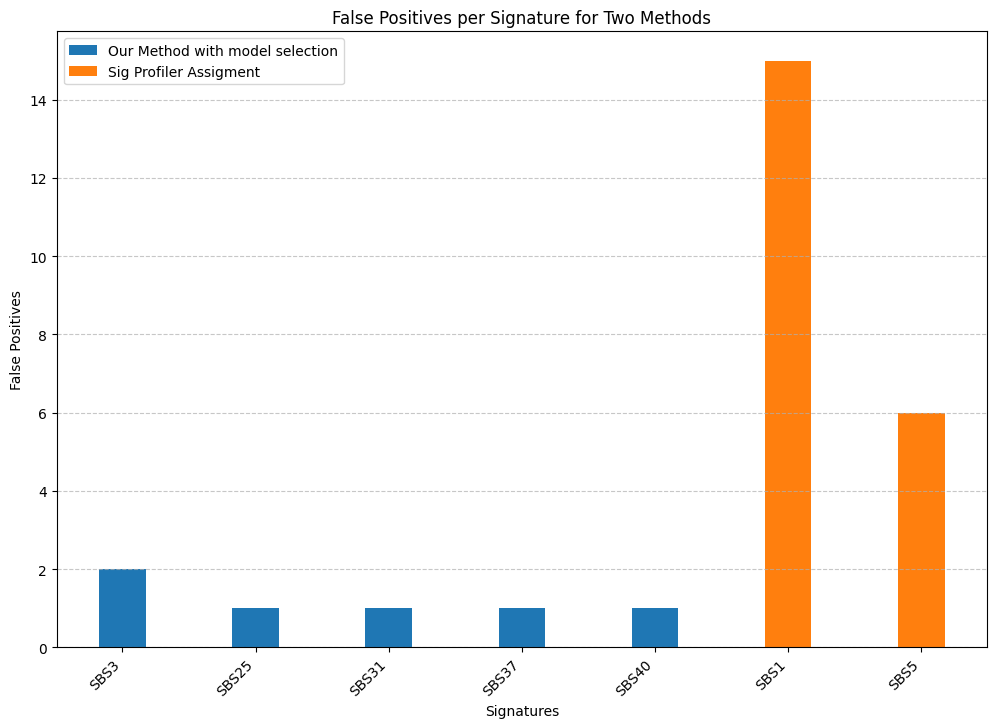

In [92]:
import matplotlib.pyplot as plt

# Twoje wcześniejsze ustawienia i dane
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35

# Rysowanie wykresów słupkowych
bar1 = ax.bar(grouped_fp_our['signatures_cat_our'], grouped_fp_our['Count'], bar_width, label='Our Method with model selection')
bar2 = ax.bar(grouped_fp_sig_profile['signatures_cat_sig_profile'], grouped_fp_sig_profile['Count'], bar_width, label='Sig Profiler Assigment')
#bar3 = ax.bar(combined_df_fp['signature_falsepositive_signal'] + bar_width/2, combined_df_fn['Count'], bar_width, label='Signal')

# Ustawienia etykiet i tytułu
ax.set_xlabel('Signatures')
ax.set_ylabel('False Positives')
ax.set_title('False Positives per Signature for Two Methods')
ax.legend()
plt.xticks(rotation=45, ha='right')

# Dodanie siatki i wyświetlenie wykresu
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [85]:
import pandas as pd
import numpy as np

# Funkcja do tworzenia wektora dla danej grupy
def create_vector(group):
    vector = np.zeros(67)
    for _, row in group.iterrows():
        index = row['best_columns']
        if index < 67:
            vector[index] = row['findSigExposures']
    return vector

def spearman_correlation(x, y):
    rx = np.argsort(np.argsort(x))
    ry = np.argsort(np.argsort(y))  
    return np.corrcoef(rx, ry)[0, 1]
    

# Grupowanie i tworzenie wektorów dla df1 i df2
groups_df1 = ground_truth_df.groupby('Sample Names').apply(create_vector)
groups_df2 = experiment_df.groupby('Sample Names').apply(create_vector)

correlations_our = {}
# Obliczanie korelacji dla każdej grupy
for sample_name in groups_df1.index:
    try:
        correlation = np.corrcoef(groups_df1[sample_name], groups_df2[sample_name])[0, 1]
        correlation_spearman = spearman_correlation(groups_df1[sample_name], groups_df2[sample_name])
        correlations_our[sample_name] = correlation_spearman
    except:
        print(sample_name)
correlations_df_our = pd.DataFrame(list(correlations_our.items()), columns=['Sample Names', 'Correlation'])

In [25]:
# Grupowanie i tworzenie wektorów dla df1 i df2
groups_df1 = ground_truth_df.groupby('Sample Names').apply(create_vector)
groups_df2 = experiment_sig_profiler_df.groupby('Sample Names').apply(create_vector)

correlations_sig_profile = {}
# Obliczanie korelacji dla każdej grupy
for sample_name in groups_df1.index:
    try:
        correlation = np.corrcoef(groups_df1[sample_name], groups_df2[sample_name])[0, 1]
        correlation_spearman = spearman_correlation(groups_df1[sample_name], groups_df2[sample_name])
        correlations_sig_profile[sample_name] = correlation_spearman
    except:
        print(sample_name)
correlations_df_sig_profile = pd.DataFrame(list(correlations_sig_profile.items()), columns=['Sample Names', 'Correlation'])

0


In [26]:
# Grupowanie i tworzenie wektorów dla df1 i df2
groups_df1 = ground_truth_df.groupby('Sample Names').apply(create_vector)
groups_df2 = experiment_signal_df.groupby('Sample Names').apply(create_vector)

correlations_signal = {}
# Obliczanie korelacji dla każdej grupy
for sample_name in groups_df1.index:
    try:
        correlation = np.corrcoef(groups_df1[sample_name], groups_df2[sample_name])[0, 1]
        correlation_spearman = spearman_correlation(groups_df1[sample_name], groups_df2[sample_name])
        correlations_signal[sample_name] = correlation_spearman
    except:
        print(sample_name)
correlations_df_signal = pd.DataFrame(list(correlations_signal.items()), columns=['Sample Names', 'Correlation'])

0


In [27]:
correlations_df_our['Correlation'].mean(), correlations_df_sig_profile['Correlation'].mean(), correlations_df_signal['Correlation'].mean()

(0.9870239444488786, 0.9933265045535239, 0.9933265045535239)

In [32]:
import pandas as pd 

def save_to_dataframe(best_columns, findSigExposures, cancer_type, patient):
    """
    Saves the best_columns and findSigExposures to a pandas DataFrame.
    """
    # Create a DataFrame with findSigExposures as a column
    df = pd.DataFrame(findSigExposures, columns=['findSigExposures'])
    # Add the best_columns as another column, ensuring the length matches
    # If best_columns is shorter, pad with None or a default value
    df['best_columns'] = pd.Series(best_columns).reindex(df.index)
    df['Cancer Types'] = cancer_type
    df['Sample Names'] = patient

    return df

import numpy as np

tumorBRCA = np.genfromtxt('data/data_for_deconstructSigs.csv', delimiter='\t', skip_header=1)
tumorBRCA = np.delete(tumorBRCA, 0, axis=1)

df = pd.read_csv('data/signatures_in_sample.csv')
SigProfilerAssignment = pd.read_csv('output/Assignment_Solution/Activities/Assignment_Solution_Activities.txt',sep='\t')


ground_truth = SigProfilerAssignment.drop(columns=['Samples'])

ground_truth.columns = [x for x in range(0, 67)]
ground_truth_df = pd.DataFrame()

for i in range(tumorBRCA.shape[1]):
    first_col = tumorBRCA[:, i]
    patient = ground_truth.iloc[i]
    patient = patient / patient.sum()

    non_zero_condition = (patient != 0)
    indexes = non_zero_condition[non_zero_condition].index.tolist()

    r = save_to_dataframe(indexes, patient[indexes].to_numpy(), SigProfilerAssignment.iloc[i]['Samples'], 'Head-SCC')
    ground_truth_df = pd.concat([r, ground_truth_df], ignore_index=True)


ground_truth_df.to_csv('output/experiment_sig_profiles.csv')

In [ ]:
SigProfilerAssignment

In [30]:
pd.read_csv('output/signal.exposures.csv',sep=',')

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60,SBS84,SBS85,unassigned
0,11787.442144,0.000000,12831.825613,0.0,9614.187995,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,4220.961417
1,8060.033832,2711.523828,12226.606252,0.0,17247.361148,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,5213.718704
2,4783.520779,13675.096447,0.000000,0.0,24547.816509,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,593.649329
3,4530.491120,0.000000,13190.287519,0.0,22177.865395,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,2896.438783
4,4047.060610,4412.960910,16964.689243,0.0,12308.660438,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,3361.072346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4150.699793,0.000000,0.000000,0.0,40942.797838,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,4906.502369
496,6686.681050,0.000000,0.000000,0.0,16529.992433,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,9004.508037
497,0.000000,0.000000,0.000000,0.0,0.000000,0.0,27024.442220,10357.419048,2716.563197,0.0,...,0,0,0,0,0,0,0,0,0,2926.309639
498,0.000000,0.000000,0.000000,0.0,0.000000,0.0,43926.941681,4727.277627,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1345.780692


In [35]:
import pandas as pd 



import numpy as npdata

tumorBRCA = np.genfromtxt('data/data_for_deconstructSigs.csv', delimiter='\t', skip_header=1)
tumorBRCA = np.delete(tumorBRCA, 0, axis=1)

df = pd.read_csv('data/signatures_in_sample.csv')
signalAssignment = pd.read_csv('output/signal.exposures.csv',sep=',')


ground_truth = signalAssignment.drop(columns=['unassigned'])

ground_truth.columns = [x for x in range(0, 67)]
ground_truth_df = pd.DataFrame()

for i in range(tumorBRCA.shape[1]):
    first_col = tumorBRCA[:, i]
    patient = ground_truth.iloc[i]
    patient = patient / patient.sum()

    non_zero_condition = (patient != 0)
    indexes = non_zero_condition[non_zero_condition].index.tolist()

    r = save_to_dataframe(indexes, patient[indexes].to_numpy(), str(i), 'Head-SCC')
    ground_truth_df = pd.concat([r, ground_truth_df], ignore_index=True)


ground_truth_df.to_csv('experiment_signal.csv')